In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import plotly.express as px
import os, sys, glob

In [ ]:
#užduotis :
# ar yra priklausomybė tarp paradvėjo vietovėje 
# esančio vidutinio atlyginimo ir parduodamo automobilio kainos?
#panaudokite regplot.

In [2]:
DB = sqlite3.connect('../DATA/WEBscr.db')
C = DB.cursor()

#sql užklausa per pandas sql_query
sql="""select * from TAutos"""
dfautos = pd.read_sql_query(sql, con=DB)

#sql užklausa per pandas sql_query
sql="""select * from TUrl"""
dfurl = pd.read_sql_query(sql, con=DB)
dfurl.head()

C.close()
DB.close()

In [17]:
def getplpr(x:str) -> tuple[str, float]:
    *_, pl, pr = x.split(';')
    pl = pl.strip()
    if pr.count('€') > 1:
        p1, *_, p2 = pr.strip().split('\n')
        pr = float(p2.replace('€','').replace(' ',''))
    else:
        pr = float(pr.replace('€','').replace(' ',''))
    return pl, pr

places, places_short, prices = [], [], []
for f in dfurl['params'].values:
    p, r = getplpr(str(f))
    places_short.append(p[:4])
    places.append(p)
    prices.append(r)
    
df = dfurl[['id', 'params']]
df['PL'] = places
df['PLC'] = places_short
df['PR'] = prices

In [16]:
dfa = pd.read_csv('../DATA/atlyginimai.csv')
dfa = dfa[['Sav.', 'Bruto, EUR']]
dfa.columns = ['Sav', 'Eur']
dfa['Sav'] = dfa['Sav'].str[:4]
dfa.drop_duplicates(subset=['Sav'], inplace=True)
dfa['Eur'] = dfa['Eur'].str.replace(' ','').str.replace(',','.').str.replace('\xa0','').apply(float)

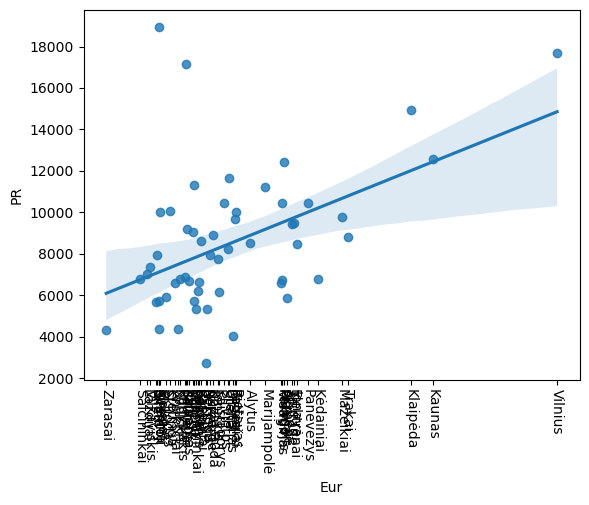

In [47]:
dfs = pd.merge(left=df, right=dfa, left_on='PLC', right_on='Sav')
dfgr = dfs.groupby('PL').mean(numeric_only=True).reset_index()
vs = dfgr[['PL', 'Eur']].sort_values(by='Eur')
ax = sns.regplot(data=dfgr, x='Eur',y='PR')
vs.head(1)
ax.set_xticks(vs['Eur'].values.tolist())
ax.set_xticklabels(vs['PL'].values.tolist())
ax.tick_params(axis='x', rotation=-90)
plt.show()